# 05/24/2022 - Running MGE and JAM on J0037 cleanly using functions from script slacs_mge_jampy.py using bspline model for photometry instead of the HST image.

In [2]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from astropy.cosmology import Planck18 as cosmo  # Planck 2018

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

# my functions
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model

################################################################
# some needed constants
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

In [2]:
# specify object directory and name

data_dir = '/home/shawn/data/' # data directory
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
file_dir = f'{data_dir}CF_mosaics/{obj_name}/' # directory with all files of obj_name

# First look at the KCWI integrated datacube and HSTF435W image, crop to 3 arcsec

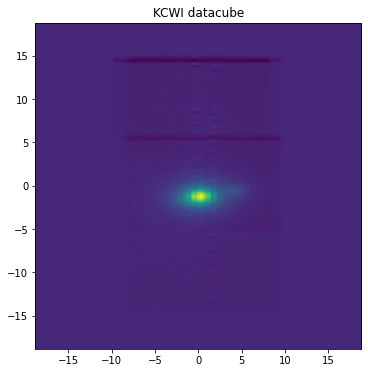

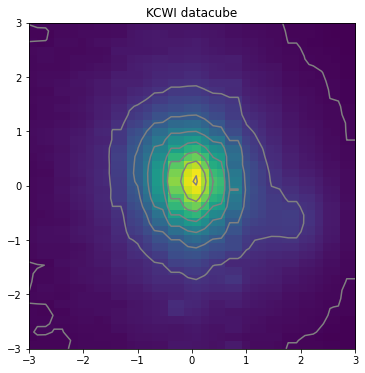

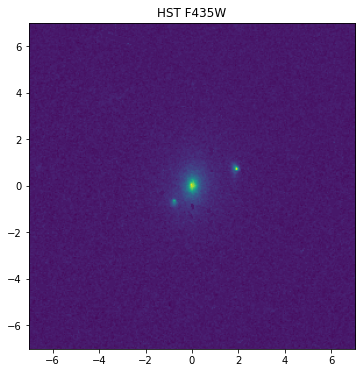

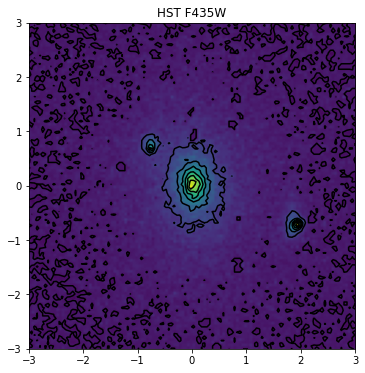

In [3]:
# import image, center, and crop

'''
My image is out to ~6 arcsec
'''
# effective radius in V band
# take photometry out to 4-5 r_eff
# r_eff_V = 2.68

#######################################################################################
# kcwi datacube

kcwi_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                          data_source='kcwi_datacube', plot=True)

#######################################################################################
# F435W cutout

hstF435_img, hstF435_3arc_img, hstF435_header, \
    central_pix_x, central_pix_y = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                      data_source='F435W', plot=True)


# Estimate PSF using Gaussian MGE for each image...

Matt Auger:

Yep, the first HDU contains the image. I *think* that others are: 2nd HDU is the inverse variance, 3rd is a cosmic ray mask, 4th is a model for the PSF, the next 3 HDUs are masks (for the lensed arc features or interloper objects), the next is a b-spline model for the lensing galaxy light, the following one is the same except deconvolved, and then a smaller cutout for the PSF.

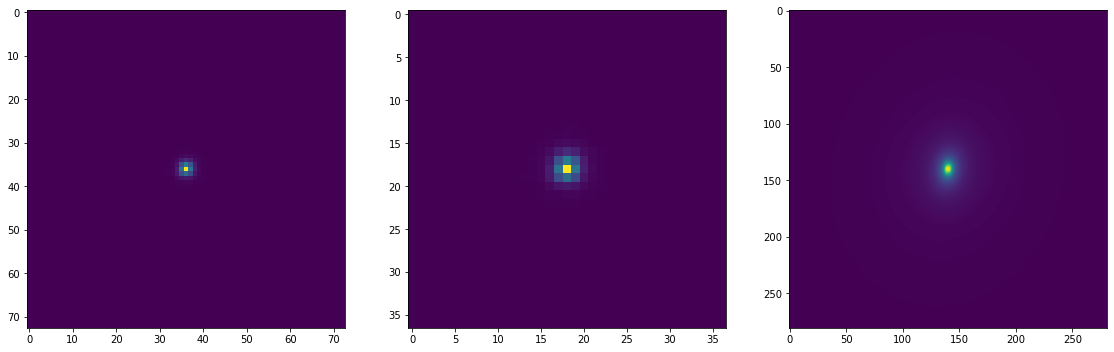

In [5]:
# Let's look at the HST image first
file = f'{file_dir}{obj_name}_F435W.fits'
hdul = fits.open(file)

plt.figure()
plt.tight_layout()

#######################################################################################
# 4th hdu is psf
psf_hdu = hdul[3]
hst_psf_model = psf_hdu.data
hst_psf_header = psf_hdu.header
#print(hst_psf_header) # header is not useful
plt.subplot(131)
plt.imshow(hst_psf_model)

#######################################################################################
# 10th hdu is smaller psf
psf_small_hdu = hdul[9]
hst_psf_small_model = psf_small_hdu.data
hst_psf_small_header = psf_small_hdu.header
#print(psf_header) # header is not useful
plt.subplot(132)
plt.imshow(hst_psf_small_model)


#######################################################################################
# 8th hdu is bspline model
bspline_hdu = hdul[7]
hst_bspline_model = bspline_hdu.data
hst_bspline_header = bspline_hdu.header
#print(bspline_header)
plt.subplot(133)
plt.imshow(hst_bspline_model)
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
plt.pause(1)


# Fit the PSF model with Gaussian MGE.

In [5]:
# fit the small model psf with Gaussian mge

#find_galaxy

#try_fractions_for_find_galaxy(hst_psf_model)


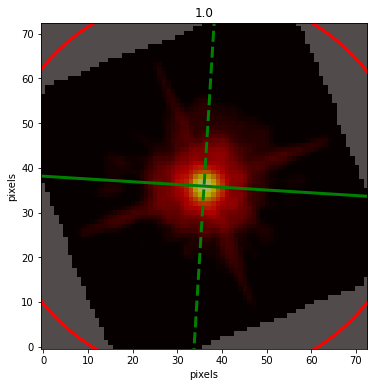

0.05042878760754688 3.5415987526017574


In [6]:
# Just use the whole image.
frac = 1.0

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(hst_psf_model, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)

print(eps, theta)

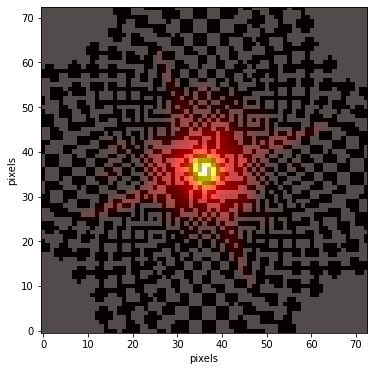

In [7]:
# It's basically circular, but I don't know how to do this as 1D. 
# run sectors photometry
plt.clf()
s = sectors_photometry(hst_psf_model, eps, theta, cen_x, cen_y, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


Iteration:1  chi2: 155.5  Nonzero: 7/12
Nonzero Gaussians: 6/12
Eliminating not useful Gaussians...
ngauss: 5          chi2: 134.2
Starting nonlinear fit...
Iteration:1  chi2: 134.2  Nonzero: 5/5
Nonzero Gaussians: 5/5
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.23 seconds
  Total Iterations:  10
 Nonzero Gaussians:  5
  Unused Gaussians:  7
 Sectors used in the fit:  19
 Total number of points fitted:  424
 Chi2: 134.1 
 STDEV: 0.465 
 MEANABSDEV: 0.4111 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  1.176437e-01     0.380000     0.932621
  5.616214e-01     0.966834     1.000000
  1.850400e-01      1.59761     1.000000
  6.106347e-02      3.22752     0.955569
  7.608733e-02      7.46306     1.000000
++++++++++++++++++++++++++++++++++++++++++++


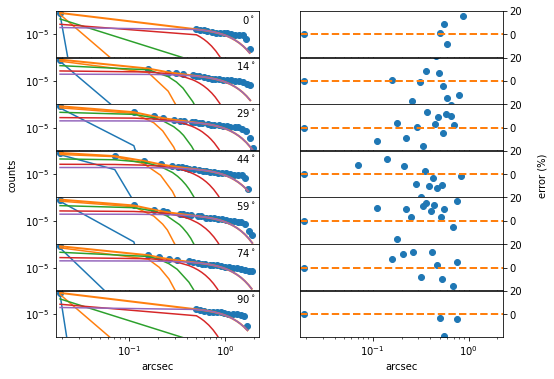

In [8]:
############################################################################################################################

# select number of gaussians to fit

scale = hst_scale
ngauss = 12

###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, #sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the output weights and sigmas for each Gaussian

hst_psf_weights = m.sol[0] # unnormalized weights in counts of each Gaussian
hst_normpsf = hst_psf_weights / np.sum(hst_psf_weights) # normalized weights for psf
hst_sigmapsf = m.sol[1] # sigma of each Gaussian


# What about the KCWI PSF? Waiting on Michele's response.
___________________________

# Now go ahead and fit the HST bspline model.

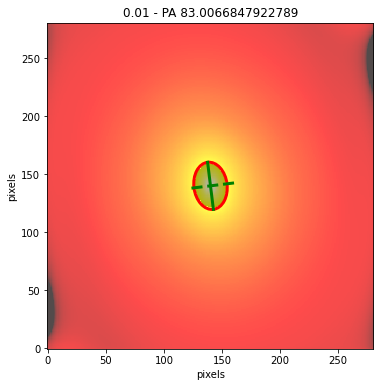

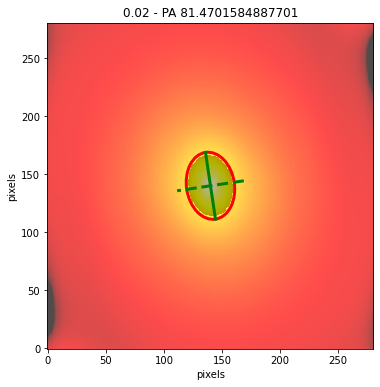

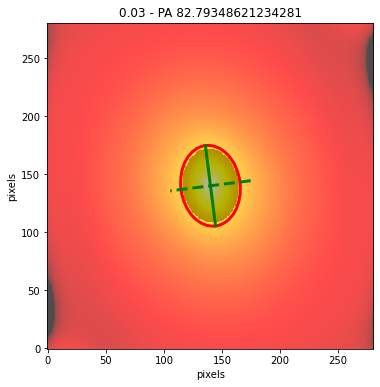

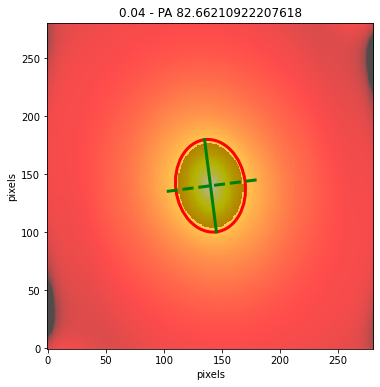

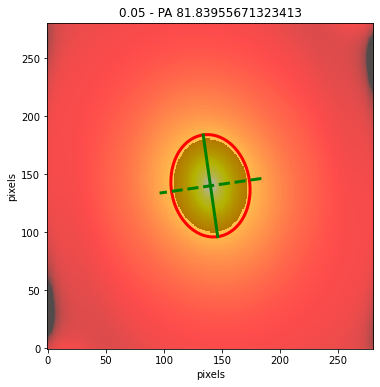

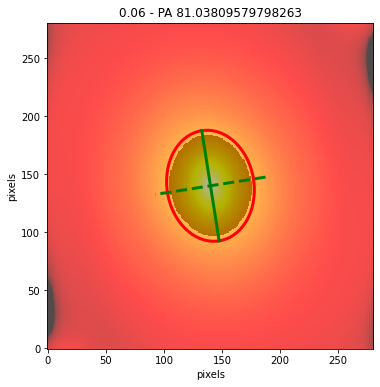

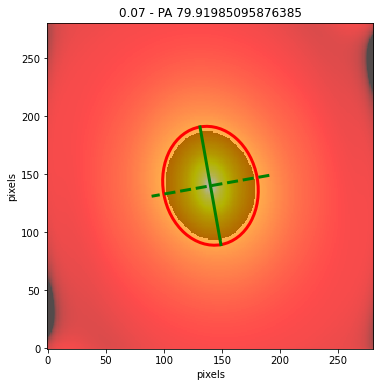

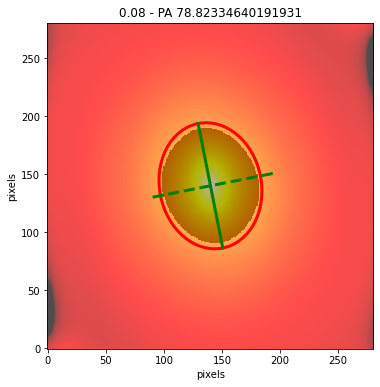

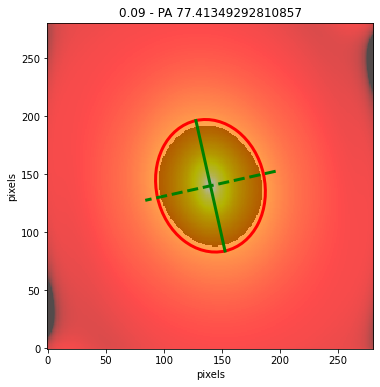

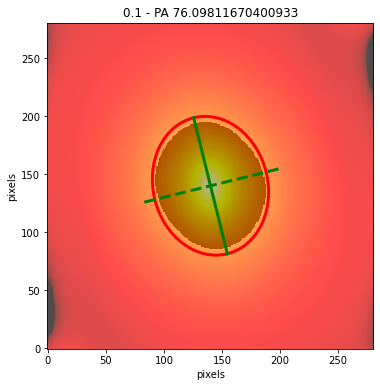

In [9]:
# take 3 arcsec hst image for find_galaxy initial estimates of PA and ellipticity

img = hst_bspline_model

############################################################################################################################
# figure out the pixel fraction best to use

#try_fractions_for_find_galaxy(img)

In [10]:
# set the fraction to be used as frac

frac = 0.25

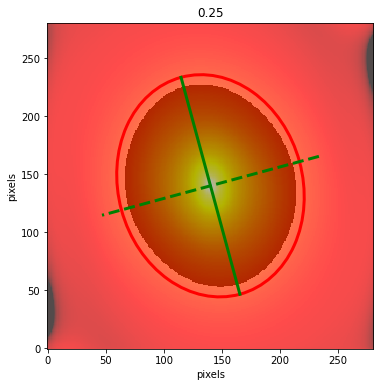

In [11]:

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)


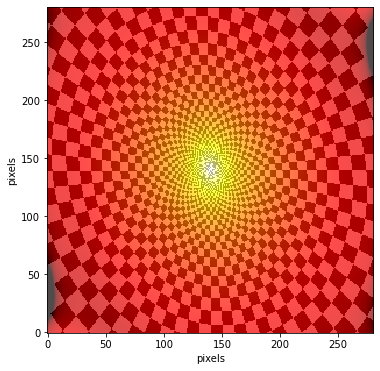

In [12]:
################################################
# Perform galaxy photometry

'''
I don't have a good selection for this? I'm guessing it's really like the noise level?
'''
# minlevel = 0  # counts/pixel 

plt.clf()
s = sectors_photometry(img, eps, theta, cen_x, cen_y, plot=1)
plt.pause(1)  # Allow plot to appear on the screen

Iteration:1  chi2: 19.53  Nonzero: 8/12
Iteration:11  chi2: 13.36  Nonzero: 9/12
Nonzero Gaussians: 8/12
Eliminating not useful Gaussians...
ngauss: 7          chi2: 13.40
ngauss: 6          chi2: 13.44
Starting nonlinear fit...
Iteration:1  chi2: 13.44  Nonzero: 6/6
Iteration:11  chi2: 13.37  Nonzero: 6/6
Iteration:21  chi2: 13.36  Nonzero: 6/6
Iteration:31  chi2: 13.36  Nonzero: 6/6
Iteration:41  chi2: 13.35  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 1.51 seconds
  Total Iterations:  19
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  716
 Chi2: 13.35 
 STDEV: 0.1353 
 MEANABSDEV: 0.05575 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  8.785748e-01     0.823187     0.710701
  3.047237e+01      3.89841     0.740191
  7.07657

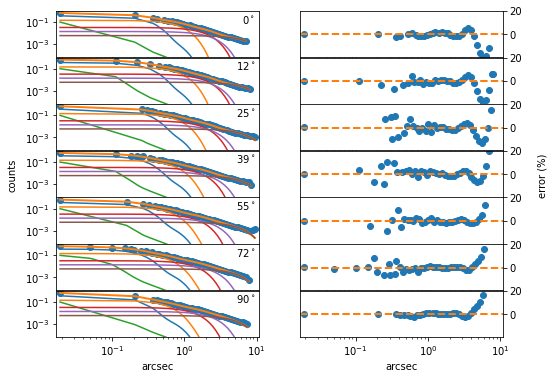

In [13]:
############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12

# pixel scale
scale = hst_scale

# psf - take from the MGE psf model above
sigmapsf = hst_sigmapsf
normpsf = hst_normpsf
#seeing_fwhm = 0.1 # arcsec
#sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma

# exposure time
exp_time = hstF435_header['EXPTIME']

###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the outputs and convert to the needed units

# convert sigma from pixels to arcsec and surface brightness to surface density
sigma, surf_density, q = convert_mge_model_outputs (m, exp_time, data_source='F435W')


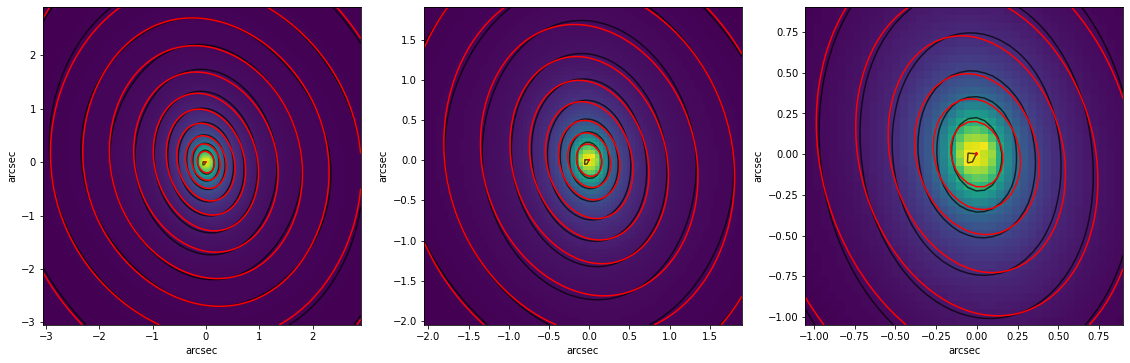

In [14]:
plot_contours_321 (img, f, m, sigmapsf, normpsf, data_source='F435W')

___________________

# Try out JAM model



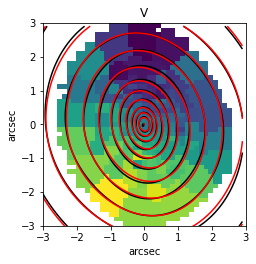

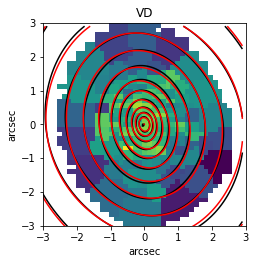

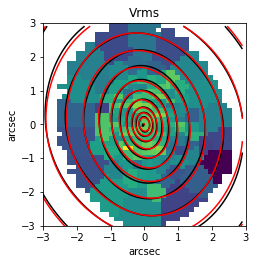

In [15]:
V, VD, Vrms, dV, dVD, dVrms, Vbary, center_axis_index = load_2d_kinematics (file_dir, obj_name, img, f, m, sigmapsf, normpsf, contour_alpha=1.0, data_source='F435W', plot=True, plot_img=False)

# This is pretty, but we need it by bins, not by pixel.

In [16]:
V_bin, VD_bin, Vrms_bin, dV_bin, dVD_bin, dVrms_bin, xbin_arcsec, ybin_arcsec = bin_velocity_maps (file_dir, obj_abbr, Vbary, center_axis_index, data_source='KCWI')

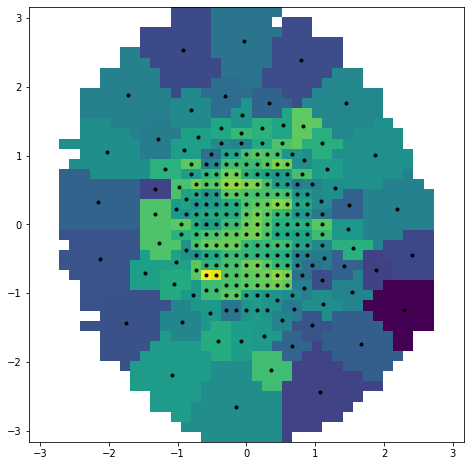

In [21]:
# Check binning

# plot with arcsec
width =  Vrms.shape[0]/2 * kcwi_scale
extent = [-width,width,-width,width]
plt.figure(figsize=(8,8))
plt.imshow(Vrms, origin='lower', extent=extent)
plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')

<Figure size 576x432 with 0 Axes>

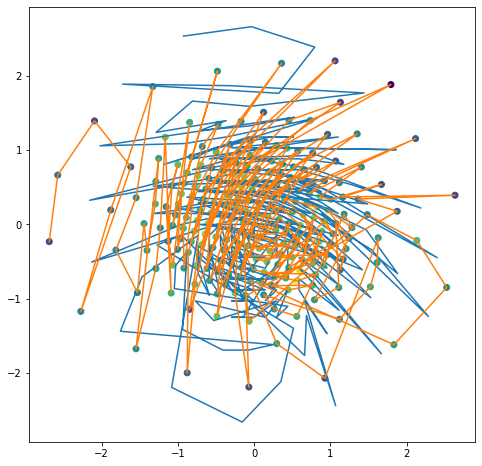

In [22]:
# rotate the bins by the PA from photomety
# plot the rotation with the "non-symmetrized velocity field"

xbin, ybin = rotate_bins (f, xbin_arcsec, ybin_arcsec, Vrms_bin, plot=True)

# JAM-time! Start with assigning beta_k to each Gaussian with Opiskov-Merrit profile

Beta(r) = 1 - 
a_ani = r_ani / r_eff


# JAM-time! Start with assigning beta_k to each Gaussian with Osipkov-Merritt profile

$$Beta(r) = \frac{r^2}{r_{ani}^2 + r^)} = \frac{1}{a_{ani}^2 (r_{eff}/r)^2 + 1}$$
$$a_{ani} = r_{ani} / r_{eff}$$

For r << r_ani, Beta ~ 0
For r >> r_ani, Beta ~ 1


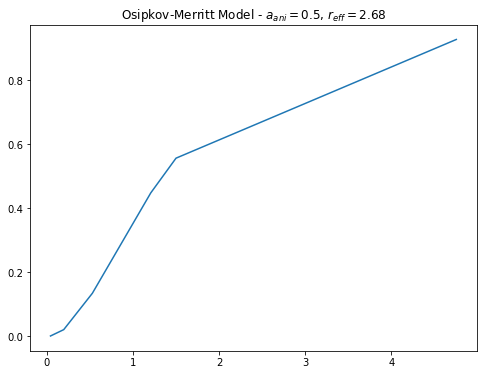

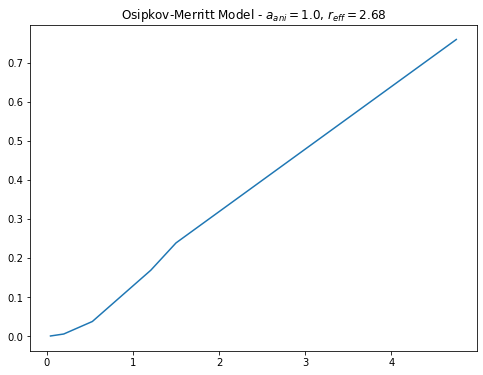

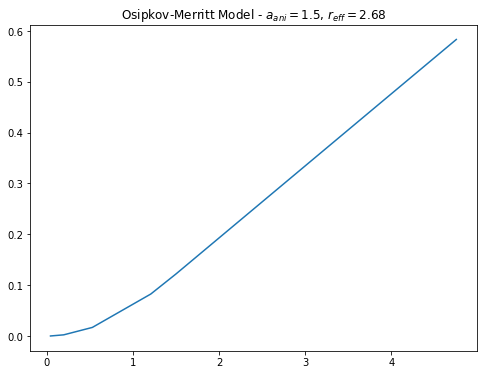

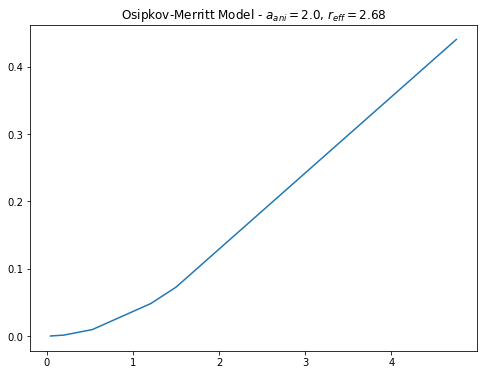

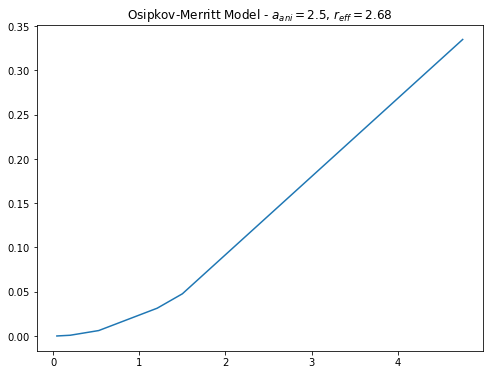

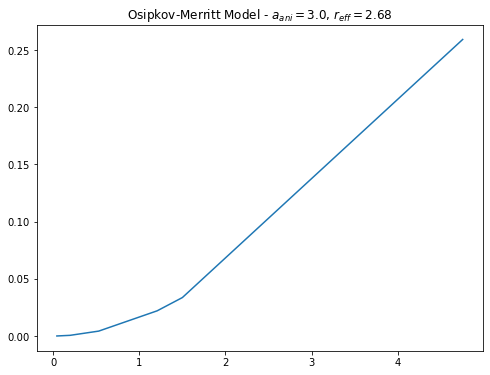

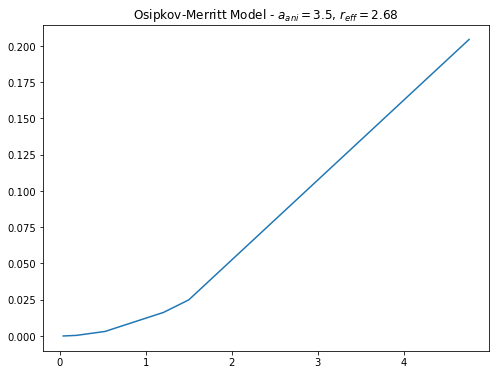

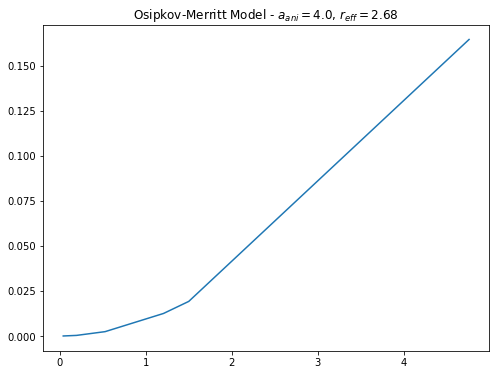

In [23]:
# take a range of values for a_ani (from TDCOSMO IV something between 1-4, likely around 1.5)
a_ani = np.arange(0.5, 4.5, 0.5)

# take the V-band effective radius? What should I actually do?
r_eff_V = 2.68 # arcsec
r_eff = r_eff_V

# take the sigma values for each Gaussian k for R
R = sigma # arcsec

# create array of Beta values for each Gaussian k
Beta = np.zeros(len(R))


for a_ani in a_ani:
    
    for i in range(len(R)):
        r = R[i]
        Beta[i] = osipkov_merritt_model(r, a_ani, r_eff)
        
    plt.clf()
    plt.plot(R, Beta)
    plt.title('Osipkov-Merritt Model - '+r'$a_{ani}=$'+f'{a_ani}, '+r'$r_{eff}=$'+f'{r_eff}') 
    plt.pause(1)

# Let's take a_ani = 2.5 for now

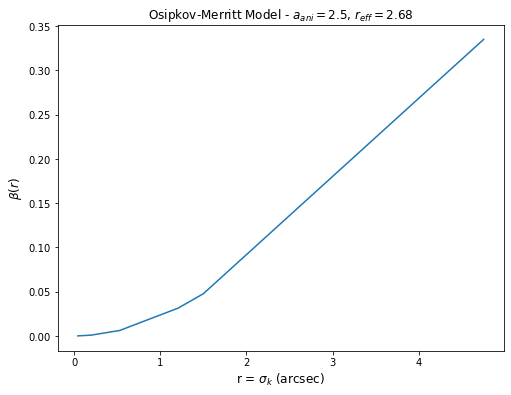

In [34]:
# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
#beta = np.full_like(surf, 0.2)

# anisotropy ratio 2.5
a_ani = 2.5

# take the V-band effective radius? What should I actually do?
r_eff_V = 2.68 # arcsec
r_eff = r_eff_V

# take the sigma values for each Gaussian k for R
sigma # arcsec

# create array of Beta values for each Gaussian k
beta = np.zeros(len(sigma))

# calculate Beta at each sigma
for i in range(len(sigma)):
        r = sigma[i]
        beta[i] = osipkov_merritt_model(r, a_ani, r_eff)
        
plt.clf()
plt.plot(sigma, beta)
plt.xlabel(r'r = $\sigma_k$ (arcsec)', fontsize=12)
plt.ylabel(r'$\beta(r)$', fontsize=12)
plt.title('Osipkov-Merritt Model - '+r'$a_{ani}=$'+f'{a_ani}, '+r'$r_{eff}=$'+f'{r_eff}') 
plt.pause(1)

In [29]:
#############################################################
# JAM Parameters

##############################################################################


'''
What do I do for inclination?
'''
inc = 80 #np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

'''
PSF is wrong, should be done with MGE
'''
# kinematics sigmapsf
seeing_fwhm = 1.0 # arcsec, typical of KCWI small slicer https://www2.keck.hawaii.edu/inst/kcwi/configurations.html
# pixel scale
sigmapsf = seeing_fwhm / 2.355

#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = kcwi_scale #0.8
goodbins = None


####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 6.19
inc=80.0; beta[0]=3.8e-05; kappa=1.00; M/L=373.; BH=3.7e+10; chi2/DOF=4.92
Total mass MGE (MSun): 4.333e+11


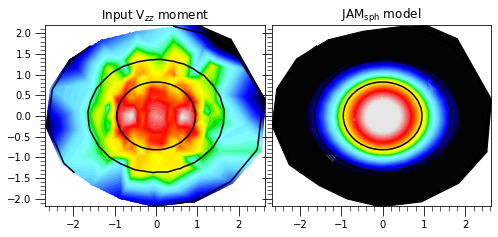

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 7.25
inc=80.0; beta[0]=3.8e-05; kappa=13.2; M/L=1.00; BH=1.0e+08; chi2/DOF=7.25
Total mass MGE (MSun): 1.162e+09


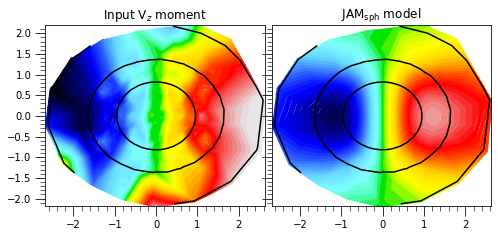

<Figure size 576x432 with 0 Axes>

In [30]:

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2


In [ ]:
# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.2)

In [37]:
#############################################################
# JAM Parameters

##############################################################################


'''
What do I do for inclination?
'''
inc = 80 #np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

'''
PSF is wrong, should be done with MGE
'''
# kinematics sigmapsf
seeing_fwhm = 0.7 # arcsec, typical of KCWI small slicer https://www2.keck.hawaii.edu/inst/kcwi/configurations.html
# pixel scale
sigmapsf = seeing_fwhm / 2.355

#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = kcwi_scale #0.8
goodbins = None


####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.93
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=362.; BH=3.6e+10; chi2/DOF=10.5
Total mass MGE (MSun): 3.182e+11


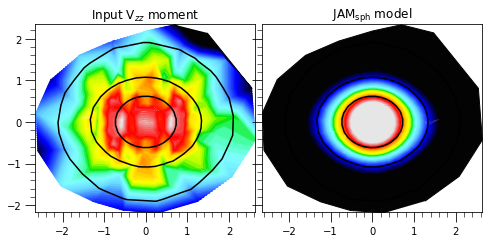

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.71
inc=80.0; beta[0]=0.20; kappa=22.0; M/L=1.00; BH=1.0e+08; chi2/DOF=14.0
Total mass MGE (MSun): 8.784e+08


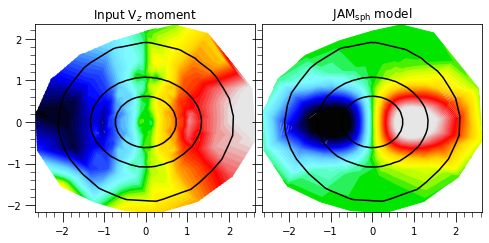

<Figure size 576x432 with 0 Axes>

In [38]:

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2


####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.82
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 6.115e+11


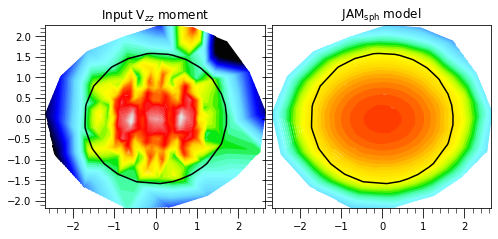

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.75
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.28
Total mass MGE (MSun): 6.112e+11


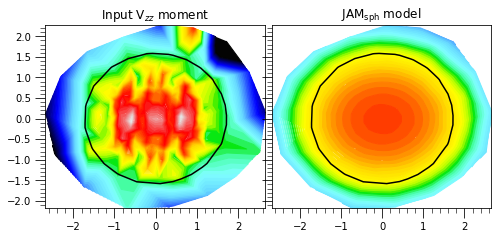

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.27
Total mass MGE (MSun): 6.111e+11


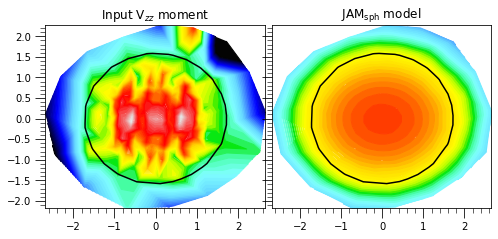

<Figure size 576x432 with 0 Axes>

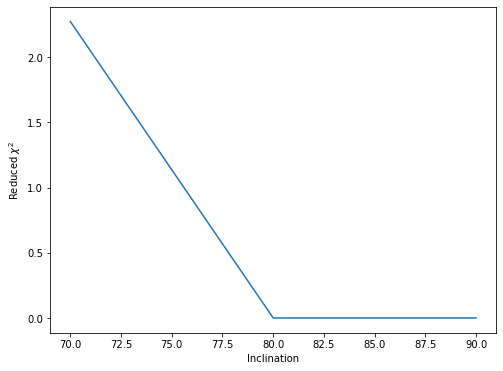

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.86
inc=70.0; beta[0]=0.20; kappa=2.22; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


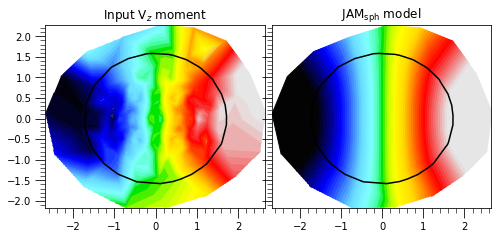

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.72
inc=80.0; beta[0]=0.20; kappa=2.42; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


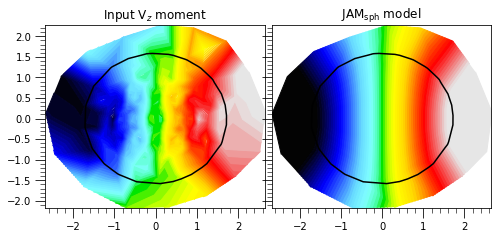

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.71
inc=90.0; beta[0]=0.20; kappa=2.49; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


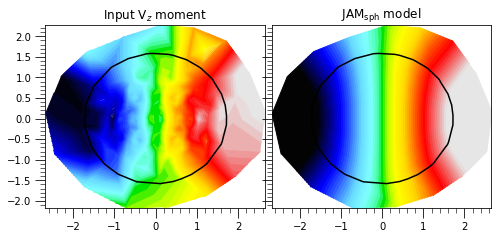

<Figure size 576x432 with 0 Axes>

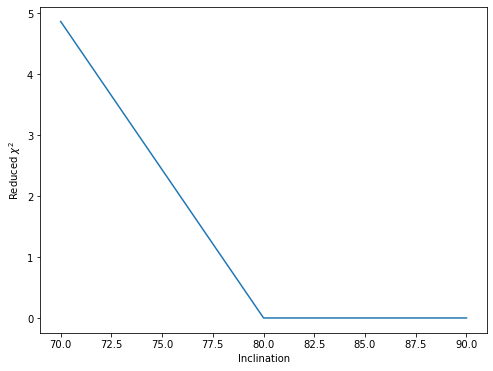

In [20]:

##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue

        # The model is by design similar but not identical to the adopted kinematics!
        m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                         inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                         sigmapsf=sigmapsf, #normpsf=normpsf,
                         beta=beta, pixsize=pixsize,
                         moment=moment, goodbins=goodbins, 
                         align='sph', ml=None, nodots=True)
        plt.pause(3)
        plt.figure(2)
        #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
        reduced_chi_squared[i] = m.chi2
        i = i+1
    
    # plot the inclinations
    plt.clf()
    fig, axs = plt.subplots()
    axs.plot(accepted_inclinations, reduced_chi_squared)
    axs.set_ylabel(r'Reduced $\chi^2$')
    axs.set_xlabel('Inclination')
    plt.pause(1)

####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.37
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.87
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 6.115e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.86
inc=70.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.21
Total mass MGE (MSun): 6.009e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.88
inc=70.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.13
Total mass MGE (MSun): 5.894e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.08
inc=70.0; beta[0]=0.50; kappa=1.00; M/L=2.92; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.770e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.66
inc=80.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.36
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.28
Total mass MGE (MSun): 6.112e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.005e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.889e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.01
inc=80.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.762e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=90.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.35
Total mass MGE (MSun): 6.210e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.27
Total mass MGE (MSun): 6.111e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.69
inc=90.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.002e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.886e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.761e+11


<Figure size 576x432 with 0 Axes>

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.84
inc=70.0; beta[0]=0.10; kappa=1.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.20; kappa=2.22; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.81
inc=70.0; beta[0]=0.30; kappa=3.16; M/L=1.00; BH=1.0e+08; chi2/DOF=4.81
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.90
inc=70.0; beta[0]=0.40; kappa=5.83; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.05
inc=70.0; beta[0]=0.50; kappa=26.9; M/L=1.00; BH=1.0e+08; chi2/DOF=5.69
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=80.0; beta[0]=0.10; kappa=1.88; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=2.42; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.30; kappa=3.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.82
inc=80.0; beta[0]=0.40; kappa=11.0; M/L=1.00; BH=1.0e+08; chi2/DOF=5.01
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.00
inc=80.0; beta[0]=0.50; kappa=2.57e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.2
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.10; kappa=1.90; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.67
inc=90.0; beta[0]=0.20; kappa=2.49; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.74
inc=90.0; beta[0]=0.30; kappa=4.08; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=15.2; M/L=1.00; BH=1.0e+08; chi2/DOF=5.17
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=2.67e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.1
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

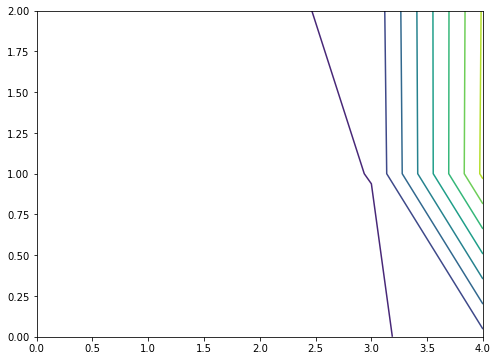

In [22]:



##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
betas = [0.1,0.2,0.3,0.4,0.5]
#beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations), len(betas)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue
        j=0
        for beta in betas:
            print('############')
            print(f'Beta of {beta}')
            beta = np.full_like(surf, beta)
            # The model is by design similar but not identical to the adopted kinematics!
            m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                             inc, mbh, distance, xbin, ybin, plot=False, data=data, errors=errors,
                             sigmapsf=sigmapsf, #normpsf=normpsf,
                             beta=beta, pixsize=pixsize,
                             moment=moment, goodbins=goodbins, 
                             align='sph', ml=None, nodots=True)
            plt.pause(3)
            plt.figure(2)
            #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
            reduced_chi_squared[i, j] = m.chi2
            j = j+1
        i = i+1

    # plot the reduced chi squared
    fig, axs = plt.subplots()
    axs.plot(reduced_chi_squared)

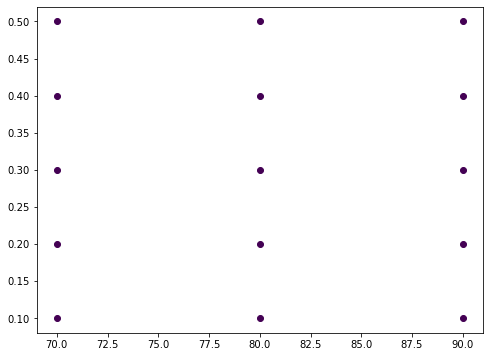

In [40]:
for i in range(len(accepted_inclinations)):
    for j in range(len(betas)):
        plt.scatter(accepted_inclinations[i], betas[j], c=reduced_chi_squared[i,j], cmap='viridis')